### Model Comparison

### Date: Jun 06, 2025

### Author: Hincal Topcuoglu, Ph.D.

In [1]:
# Imports for regression teaching
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from scipy.stats import shapiro, probplot
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

Brief Overview: Ridge and Lasso Regression

### Linear Regression

- Models the relationship between features and a continuous target by fitting a linear equation.
- Minimizes the sum of squared residuals (least squares).

### Ridge Regression (L2 Regularization)

- Adds a penalty term proportional to the square of the magnitude of coefficients to the loss function.
- Helps reduce model complexity and multicollinearity by shrinking coefficients towards zero but never exactly zero.
- Useful when many features are correlated.

### Lasso Regression (L1 Regularization)

- Adds a penalty term proportional to the absolute value of coefficients.
- Can shrink some coefficients exactly to zero, effectively performing feature selection.
- Useful for sparse models where only a subset of features are important.


### Key Differences:
- Aspect	         Ridge Regression	          Lasso Regression
- Penalty type	     L2 (squared coefficients)	  L1 (absolute coefficients)
- In Ridge Regression: Shrinks coefficients but keeps all,Use case	Multicollinearity, many correlated features
- In Lasso Regression:Shrinks and sets some to zero (feature selection), Use case Feature selection, sparse models

In [2]:
data = pd.read_csv('insurance.csv')

In [3]:
data.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [4]:
data.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


In [5]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

Hincal Comment:

Since we did feature engineering steps before, I will apply them here directly

In [6]:
# normalize data
data['age_normalized'] = (data.age-data.age.min())/(data.age.max()-data.age.min())

data['bmi_normalized'] = (data.bmi-data.bmi.min())/(data.bmi.max()-data.bmi.min())

data['children_normalized'] = (data.children-data.children.min())/(data.children.max()-data.children.min())

data['expenses_normalized'] = (data.expenses-data.expenses.min())/(data.expenses.max()-data.expenses.min())

# Box-Cox transformation (data must be strictly positive)
# If there are zeros or negatives, you need to shift the data
expenses_positive = data['expenses'] + 1 if (data['expenses'] <= 0).any() else data['expenses']
data['expenses_boxcox'], fitted_lambda = boxcox(expenses_positive)

In [7]:
data.head()

,age,sex,bmi,children,smoker,region,expenses,age_normalized,bmi_normalized,children_normalized,expenses_normalized,expenses_boxcox
0,19,female,27.9,0,yes,southwest,16884.92,0.021739,0.320755,0.0,0.251611,12.128977
1,18,male,33.8,1,no,southeast,1725.55,0.000000,0.479784,0.2,0.009636,8.808593
2,28,male,33.0,3,no,southeast,4449.46,0.217391,0.458221,0.6,0.053115,10.147519
3,33,male,22.7,0,no,northwest,21984.47,0.326087,0.180593,0.0,0.333010,12.534948
4,32,male,28.9,0,no,northwest,3866.86,0.304348,0.347709,0.0,0.043816,9.945637


Hincal Comment:
After making min-max scaling to the data, lets plot their distribution

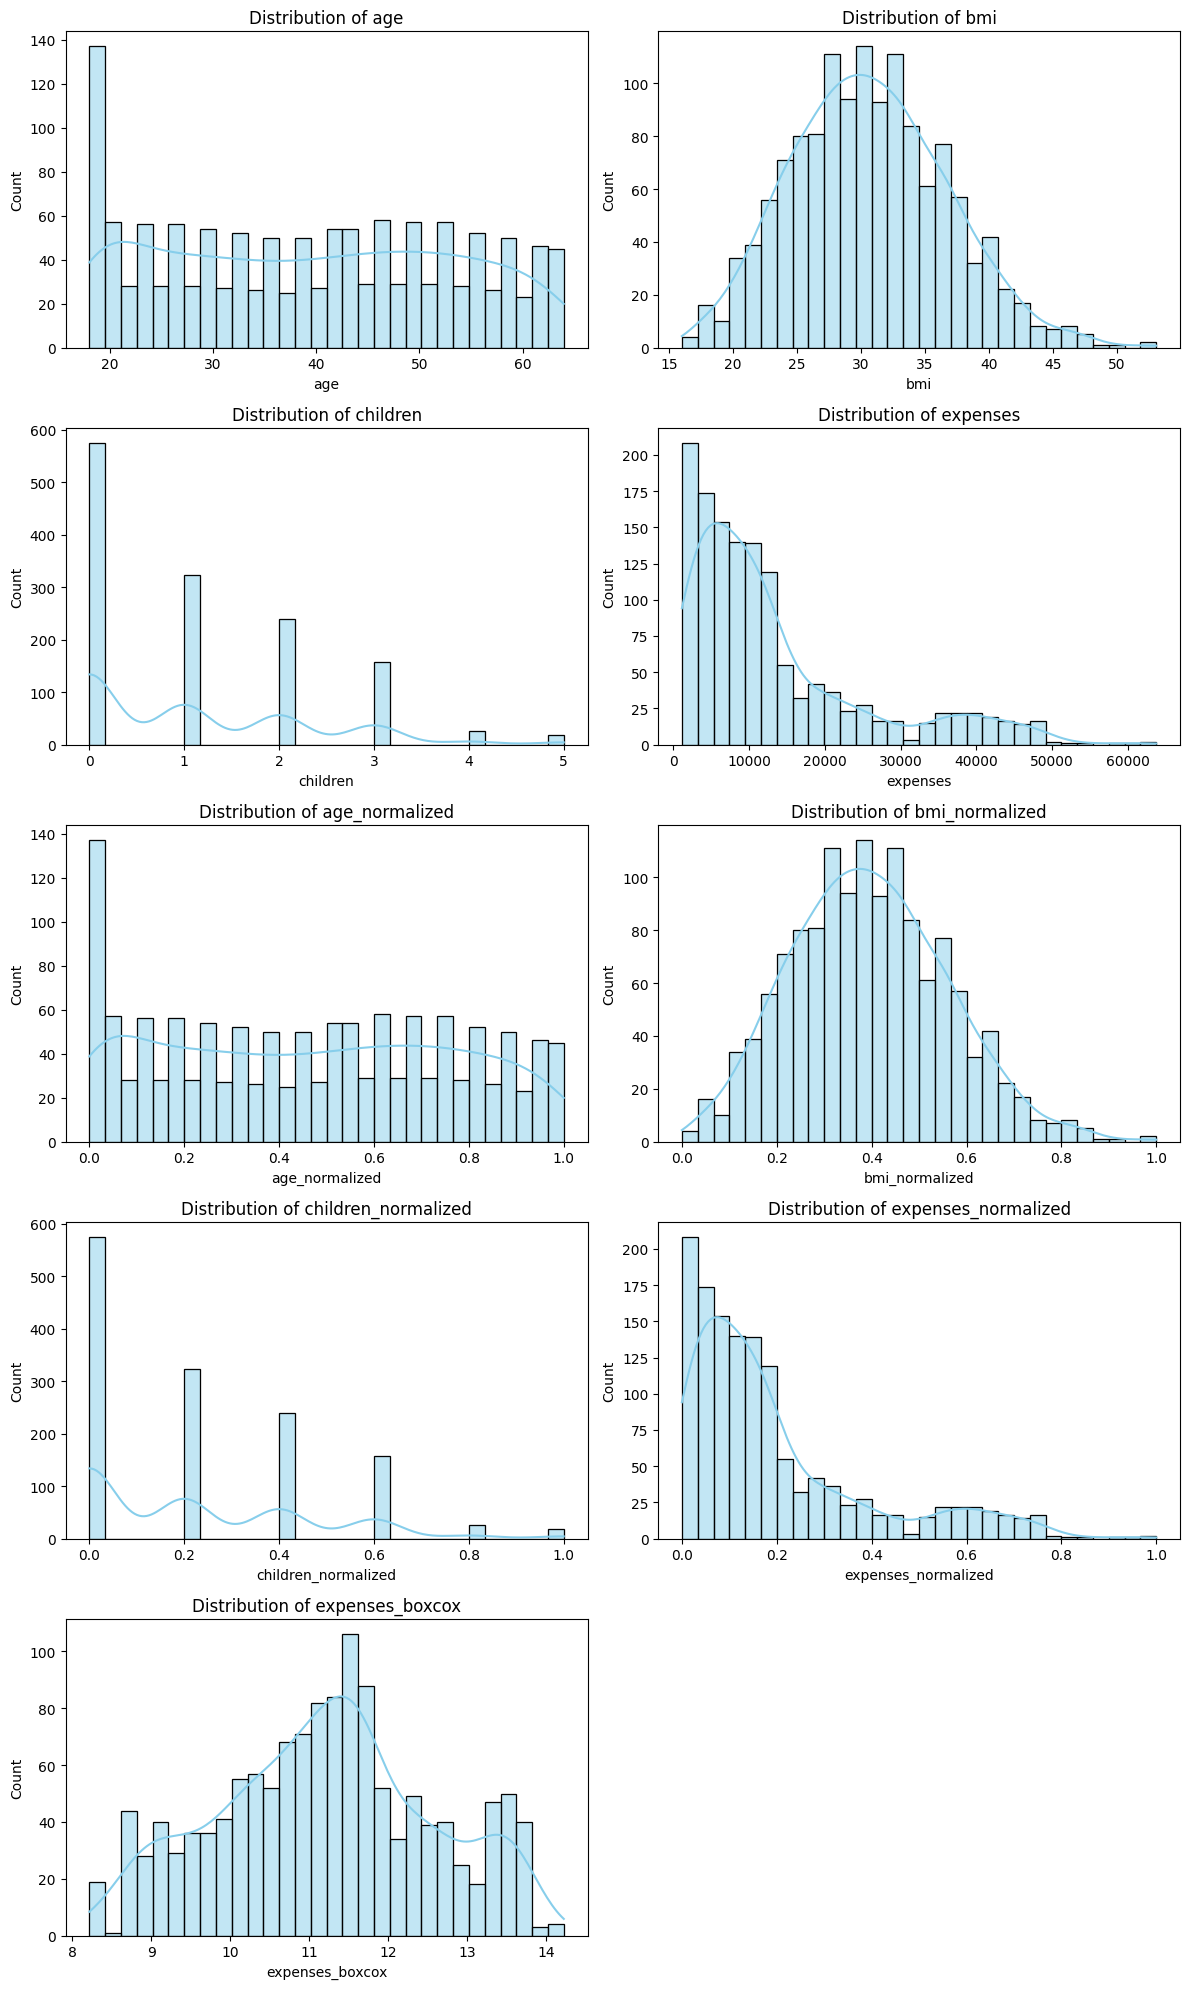

In [8]:
# Plot data
# Select continuous features (example columns, adjust as needed)
continuous_features = ['age', 'bmi', 'children', 'expenses','age_normalized', 'bmi_normalized','children_normalized','expenses_normalized','expenses_boxcox']

# Set up the plot grid
num_features = len(continuous_features)
cols = 2
rows = (num_features + 1) // cols

plt.figure(figsize=(12, rows * 4))

for i, feature in enumerate(continuous_features, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(data[feature], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

Hincal Comment:
Let's check any variable has a continious distribution

In [9]:
for col in continuous_features:
    stat, p = shapiro(data[col])
    print(f"{col}: W={stat:.4f}, p-value={p:.4f}")
    if p > 0.05:
        print("  Likely normal (fail to reject H0)")
    else:
        print("  Not normal (reject H0)")

age: W=0.9447, p-value=0.0000
  Not normal (reject H0)
bmi: W=0.9938, p-value=0.0000
  Not normal (reject H0)
children: W=0.8232, p-value=0.0000
  Not normal (reject H0)
expenses: W=0.8147, p-value=0.0000
  Not normal (reject H0)
age_normalized: W=0.9447, p-value=0.0000
  Not normal (reject H0)
bmi_normalized: W=0.9938, p-value=0.0000
  Not normal (reject H0)
children_normalized: W=0.8232, p-value=0.0000
  Not normal (reject H0)
expenses_normalized: W=0.8147, p-value=0.0000
  Not normal (reject H0)
expenses_boxcox: W=0.9835, p-value=0.0000
  Not normal (reject H0)


Hincal Comment:
Lets plot correalation heatmap

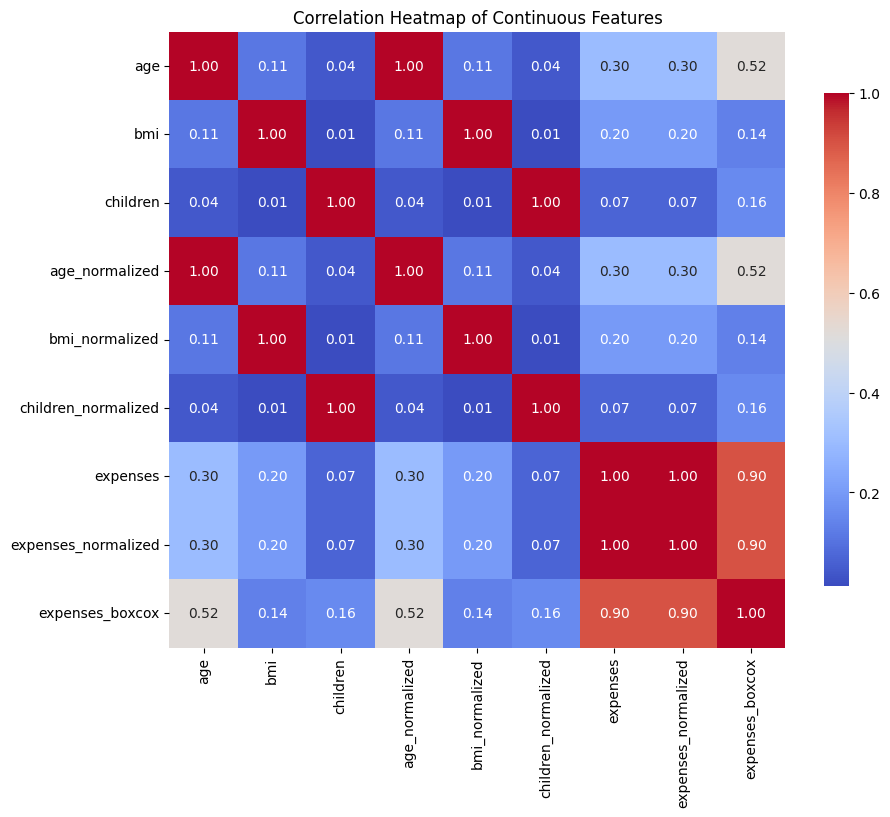

In [10]:
# Select continuous features (including normalized ones)
continuous_features = [
    'age', 'bmi', 'children',
    'age_normalized', 'bmi_normalized', 'children_normalized','expenses' ,'expenses_normalized','expenses_boxcox'
]

# Compute correlation matrix
corr_matrix = data[continuous_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Continuous Features')
plt.show()

Hincal Comment:
No highly correlated feautures especially with normal and normalized target variable except for expenses_boxcox. we will use this variable as target variable

Hincal Comment:
Lets apply Baseline Regression Model with all features

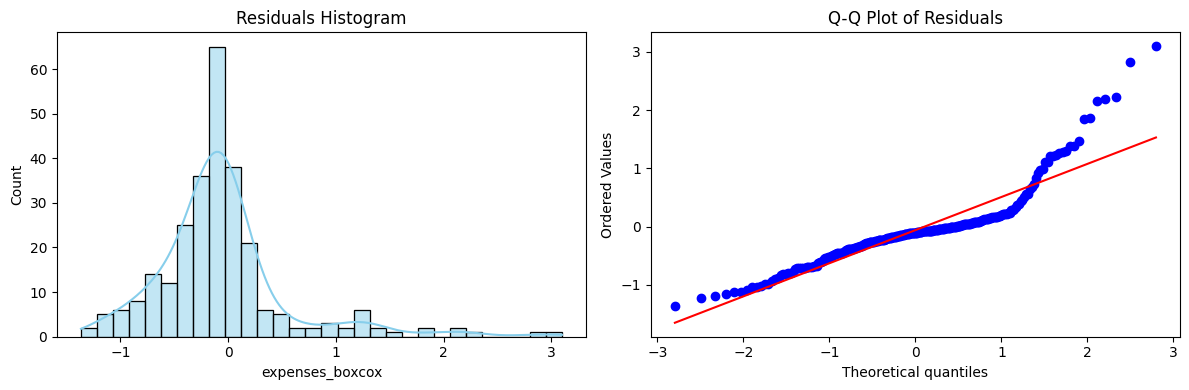

Shapiro-Wilk test: W=0.8417, p-value=0.0000
Residuals are not normal (reject H0)


{'Train R2': 0.7603300810540876,
 'Test R2': 0.8072519603092678,
 'Train MSE': 0.439518931768789,
 'Test MSE': 0.3829340038002086,
 'Train MAE': 0.4171497166768558,
 'Test MAE': 0.40076540146057604}

In [11]:
# Select features and target
features = ['age', 'bmi', 'children', 'age_normalized', 'bmi_normalized','children_normalized','sex' ,'smoker', 'region']
target = 'expenses_boxcox'

# One-hot encode categorical variables
X = pd.get_dummies(data[features], drop_first=True)
y = data[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# calculate residuals
residuals = y_test - y_test_pred

# Metrics
metrics = {}
metrics['Train R2'] = r2_score(y_train, y_train_pred)
metrics['Test R2'] = r2_score(y_test, y_test_pred)
metrics['Train MSE'] = mean_squared_error(y_train, y_train_pred)
metrics['Test MSE'] = mean_squared_error(y_test, y_test_pred)
metrics['Train MAE'] = mean_absolute_error(y_train, y_train_pred)
metrics['Test MAE'] = mean_absolute_error(y_test, y_test_pred)

# Plot residuals histogram
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(residuals, bins=30, kde=True, color='skyblue')
plt.title('Residuals Histogram')

# Q-Q plot
plt.subplot(1, 2, 2)
probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

# Shapiro-Wilk test
stat, p = shapiro(residuals)
print(f"Shapiro-Wilk test: W={stat:.4f}, p-value={p:.4f}")
if p > 0.05:
    print("Residuals are likely normal (fail to reject H0)")
else:
    print("Residuals are not normal (reject H0)")

metrics

Hincal Comment:
That's ok, we have alredy known that our baseline linear regression model doesnt in fit with in normality assumptions

Hincal Comment:
Lets see features and residual plots

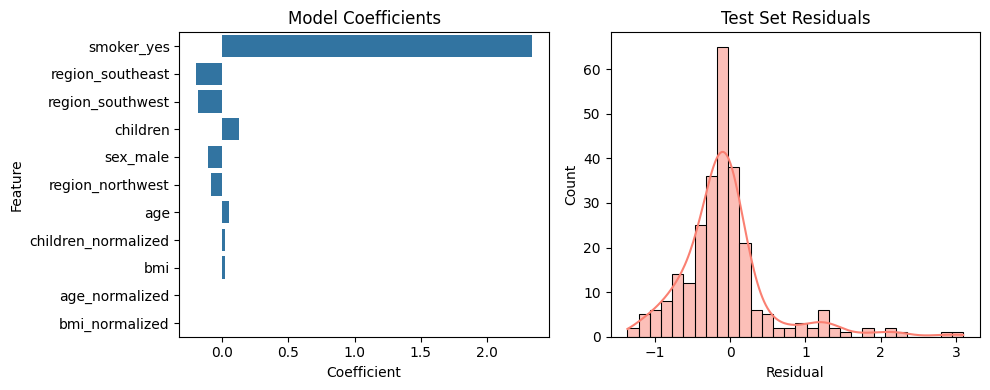

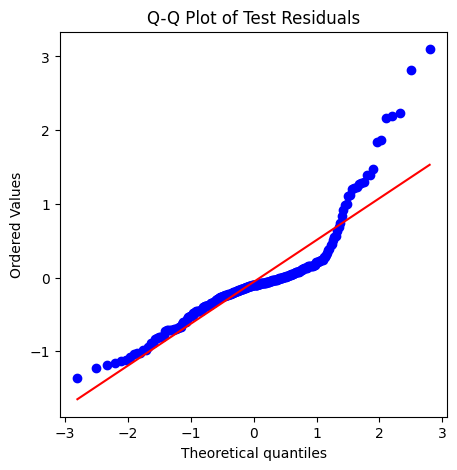

,Feature,Coefficient
7,smoker_yes,2.338156
9,region_southeast,-0.195583
10,region_southwest,-0.178204
2,children,0.127261
6,sex_male,-0.104736
8,region_northwest,-0.082311
0,age,0.050007
5,children_normalized,0.025452
1,bmi,0.020999
3,age_normalized,0.001087


In [12]:
# Coefficients
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})

# Residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Plot coefficients
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.barplot(x='Coefficient', y='Feature', data=coef_df.sort_values('Coefficient', key=abs, ascending=False))
plt.title('Model Coefficients')

# Plot residuals (test set)
plt.subplot(1, 2, 2)
sns.histplot(test_residuals, bins=30, kde=True, color='salmon')
plt.title('Test Set Residuals')
plt.xlabel('Residual')

plt.tight_layout()
plt.show()

# Q-Q plot for test residuals
import scipy.stats as stats
plt.figure(figsize=(5, 5))
stats.probplot(test_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Test Residuals')
plt.show()

# Show coefficients as a table
coef_df.sort_values('Coefficient', key=abs, ascending=False)

Hincal Comment: Lets handle outliers with quantiles and IQR values

In [13]:
# List of numeric columns to cap
numeric_cols = ['age', 'bmi', 'children', 'age_normalized', 'bmi_normalized','children_normalized','expenses_boxcox']

# Cap outliers at IQR bounds
df_capped = data.copy()
for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower, upper)

# Prepare features and target
features = ['age', 'bmi', 'children', 'age_normalized', 'bmi_normalized','children_normalized','sex', 'smoker', 'region']
target = 'expenses_boxcox'

X = pd.get_dummies(data[features], drop_first=True)
y = data[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Metrics
metrics = {
    'Train R2': r2_score(y_train, y_train_pred),
    'Test R2': r2_score(y_test, y_test_pred),
    'Train MSE': mean_squared_error(y_train, y_train_pred),
    'Test MSE': mean_squared_error(y_test, y_test_pred),
    'Train MAE': mean_absolute_error(y_train, y_train_pred),
    'Test MAE': mean_absolute_error(y_test, y_test_pred)
}

metrics

{'Train R2': 0.7605935823511023,
 'Test R2': 0.8066939592308524,
 'Train MSE': 0.43903570963939975,
 'Test MSE': 0.3840425888080007,
 'Train MAE': 0.41757357966071734,
 'Test MAE': 0.40189715025375355}

Hincal Comment:
After handling outliers, no significant change it error rates

Hincal Comment:
Lets create more feautures:

In [14]:
# Interaction features
data['age_bmi'] = data['age'] * data['bmi']
data['bmi_smoker'] = data['bmi'] * (data['smoker'] == 'yes').astype(int)
data['age_smoker'] = data['age'] * (data['smoker'] == 'yes').astype(int)

# Polynomial features
data['bmi_squared'] = data['bmi'] ** 2
data['age_squared'] = data['age'] ** 2

# Binning
data['age_group'] = pd.cut(data['age'], bins=[0, 30, 50, 100], labels=['<30', '30-50', '>50'])
data['bmi_category'] = pd.cut(data['bmi'], bins=[0, 18.5, 25, 30, 100], labels=['underweight', 'normal', 'overweight', 'obese'])

# Count/ratio
data['has_children'] = (data['children'] > 0).astype(int)
data['bmi_per_child'] = data['bmi'] / (data['children'] + 1)

# Combined categorical
data['region_smoker'] = data['region'] + '_' + data['smoker']

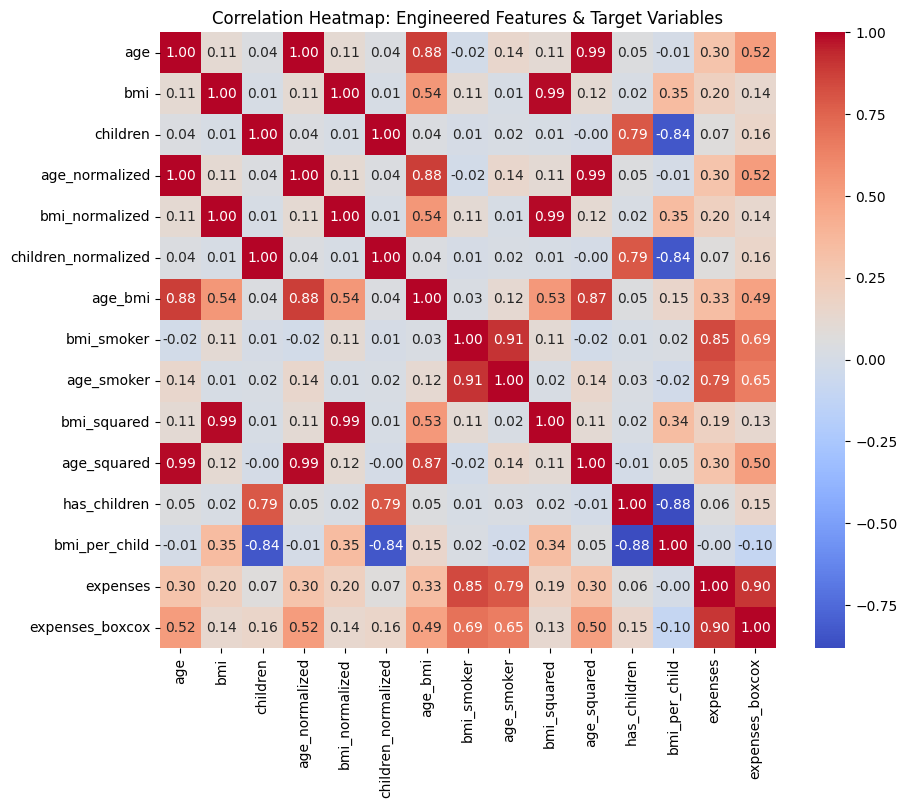

In [15]:
# List of all numeric features to check correlation
corr_features = [
    'age', 'bmi', 'children', 'age_normalized', 'bmi_normalized','children_normalized', 'age_bmi', 'bmi_smoker', 'age_smoker',
    'bmi_squared', 'age_squared', 'has_children', 'bmi_per_child',
    'expenses', 'expenses_boxcox'
]

# Only keep columns that exist in the DataFrame
corr_features = [col for col in corr_features if col in data.columns]

# Prepare DataFrame for correlation
corr_df = data[corr_features]

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap: Engineered Features & Target Variables')
plt.show()

Hincal Comment: 
- Give attention in correalation with variable:

age,

bmi

children,

age_normalized

bmi_normalized

age_bmi

age_smoker

bmi_smoker

age_squared

has_children
- There will be also a multicolinearity problem with baseline data, So I will calculate Variance Inflation factors to eliminate it

In [16]:
# Select only numeric features (excluding the target)
features = [
    'age','bmi', 'children', 'age_normalized', 'bmi_normalized',
     'age_bmi', 'age_smoker', 'bmi_smoker','age_squared'
]
X = data[features].dropna()

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

          Feature        VIF
0             age        inf
1             bmi        inf
2        children   1.102361
3  age_normalized        inf
4  bmi_normalized        inf
5         age_bmi  38.557356
6      age_smoker   7.308129
7      bmi_smoker   7.247706
8     age_squared  48.081930


/Users/hincaltopcuoglu/Desktop/webuser_trade/learning/vinj/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Hincal Comment:
Here is the problem is multicolinearity, lets handle them and calculate VIF again

Hincal Comment:
- I selected to VIF calculation those which have multicolinearity between them and also check correlation between target variable
- For example, age, age_nromalized, age_squared, they are correlation within each other but I choose age_squared which has more correlation with the target variable
- I will select variables from here VIF>= 10, and apply linear regression model again

In [17]:
vif_variables_to_calculate = ['age_normalized','bmi_normalized','children','age_smoker', 'bmi_smoker']

X = data[vif_variables_to_calculate].dropna()

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


          Feature       VIF
0  age_normalized  3.500686
1  bmi_normalized  3.817782
2        children  1.694657
3      age_smoker  8.917993
4      bmi_smoker  8.997471


Hincal Comment: 
It seems good

In [18]:
data.head()

,age,sex,bmi,children,smoker,region,expenses,age_normalized,bmi_normalized,children_normalized,...,age_bmi,bmi_smoker,age_smoker,bmi_squared,age_squared,age_group,bmi_category,has_children,bmi_per_child,region_smoker
0,19,female,27.9,0,yes,southwest,16884.92,0.021739,0.320755,0.0,...,530.1,27.9,19,778.41,361,<30,overweight,0,27.90,southwest_yes
1,18,male,33.8,1,no,southeast,1725.55,0.000000,0.479784,0.2,...,608.4,0.0,0,1142.44,324,<30,obese,1,16.90,southeast_no
2,28,male,33.0,3,no,southeast,4449.46,0.217391,0.458221,0.6,...,924.0,0.0,0,1089.00,784,<30,obese,1,8.25,southeast_no
3,33,male,22.7,0,no,northwest,21984.47,0.326087,0.180593,0.0,...,749.1,0.0,0,515.29,1089,30-50,normal,0,22.70,northwest_no
4,32,male,28.9,0,no,northwest,3866.86,0.304348,0.347709,0.0,...,924.8,0.0,0,835.21,1024,30-50,overweight,0,28.90,northwest_no


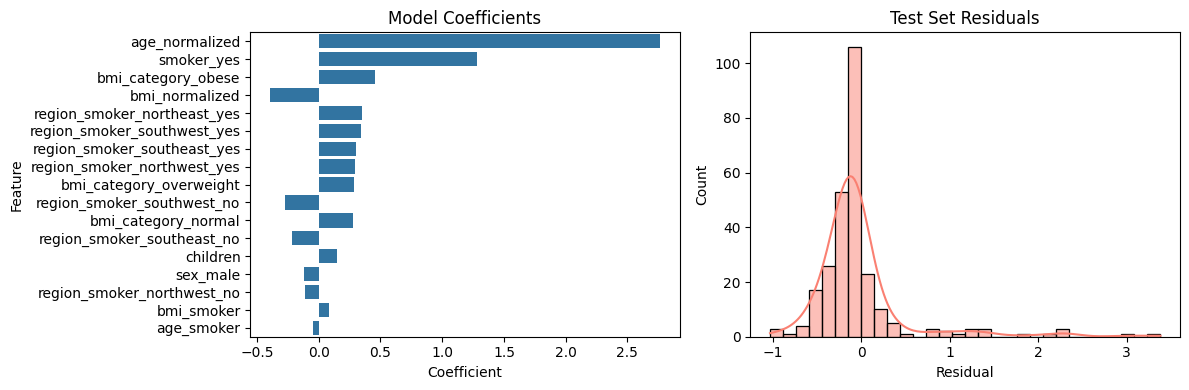

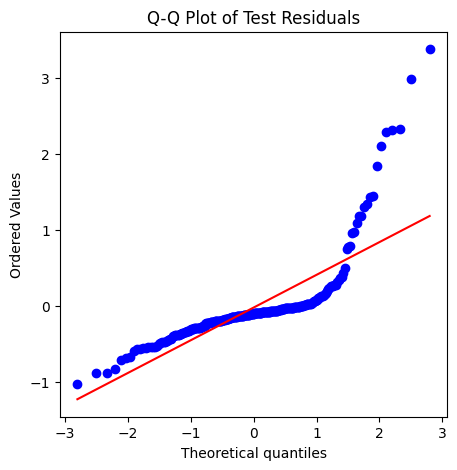

({'Train R2': 0.8207530164247442,
  'Test R2': 0.8551849911965472,
  'Train MSE': 0.3287122684826934,
  'Test MSE': 0.2877050849411831,
  'Train MAE': 0.3174346537008357,
  'Test MAE': 0.29648670204662614},
                         Feature  Coefficient
 0                age_normalized     2.766317
 1                bmi_normalized    -0.396399
 2                      children     0.145089
 3                    age_smoker    -0.047913
 4                    bmi_smoker     0.079153
 5           bmi_category_normal     0.273954
 6       bmi_category_overweight     0.286549
 7            bmi_category_obese     0.452189
 8   region_smoker_northeast_yes     0.346465
 9    region_smoker_northwest_no    -0.112606
 10  region_smoker_northwest_yes     0.289743
 11   region_smoker_southeast_no    -0.214523
 12  region_smoker_southeast_yes     0.303729
 13   region_smoker_southwest_no    -0.274046
 14  region_smoker_southwest_yes     0.344506
 15                     sex_male    -0.121469
 16        

In [19]:
# Features and target
features = ['age_normalized','bmi_normalized','children','age_smoker', 'bmi_smoker','bmi_category','region_smoker','sex','smoker']
target = 'expenses_boxcox'

# Prepare data (drop rows with missing values in selected features)
X = data[features].dropna()
y = data.loc[X.index, target]


X = pd.get_dummies(data[features], drop_first=True)
y = data[target]


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Metrics
metrics = {
    'Train R2': r2_score(y_train, y_train_pred),
    'Test R2': r2_score(y_test, y_test_pred),
    'Train MSE': mean_squared_error(y_train, y_train_pred),
    'Test MSE': mean_squared_error(y_test, y_test_pred),
    'Train MAE': mean_absolute_error(y_train, y_train_pred),
    'Test MAE': mean_absolute_error(y_test, y_test_pred)
}

# Coefficients
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})

# Residuals
test_residuals = y_test - y_test_pred

# Plot coefficients and residuals
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.barplot(x='Coefficient', y='Feature', data=coef_df.sort_values('Coefficient', key=abs, ascending=False))
plt.title('Model Coefficients')

plt.subplot(1, 2, 2)
sns.histplot(test_residuals, bins=30, kde=True, color='salmon')
plt.title('Test Set Residuals')
plt.xlabel('Residual')
plt.tight_layout()
plt.show()

# Q-Q plot for test residuals
plt.figure(figsize=(5, 5))
stats.probplot(test_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Test Residuals')
plt.show()

metrics, coef_df

Hincal Comment:

Very good model with increased R Squared and decreased error metrics

---

Hincal Comment: 
Lets apply the Ridge Regression to whole data

In [20]:
data.columns.tolist()

['age',
 'sex',
 'bmi',
 'children',
 'smoker',
 'region',
 'expenses',
 'age_normalized',
 'bmi_normalized',
 'children_normalized',
 'expenses_normalized',
 'expenses_boxcox',
 'age_bmi',
 'bmi_smoker',
 'age_smoker',
 'bmi_squared',
 'age_squared',
 'age_group',
 'bmi_category',
 'has_children',
 'bmi_per_child',
 'region_smoker']

In [21]:
# Your features list (excluding target)
features = [
    'age', 'sex', 'bmi', 'children', 'smoker', 'region',
    'age_normalized', 'bmi_normalized', 'children_normalized',
    'age_bmi', 'bmi_smoker', 'age_smoker', 'bmi_squared', 'age_squared',
    'age_group', 'bmi_category', 'has_children', 'bmi_per_child', 'region_smoker'
]

target = 'expenses_boxcox'  # or your target variable

# Separate X and y
X = data[features]
y = data[target]

# Identify categorical and numerical columns
categorical_cols = ['sex', 'smoker', 'region', 'age_group', 'bmi_category', 'has_children', 'region_smoker']
numerical_cols = [col for col in features if col not in categorical_cols]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipelines
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create pipeline with preprocessing and Ridge regression
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Ridge(alpha=1.0, random_state=42))
])

# Fit model
ridge_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = ridge_pipeline.predict(X_test)
print(f"Ridge Regression MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Ridge Regression R2: {r2_score(y_test, y_pred):.4f}")

# Extract feature names after one-hot encoding
ohe_features = ridge_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)
all_features = numerical_cols + list(ohe_features)

# Extract coefficients
ridge_coefs = ridge_pipeline.named_steps['ridge'].coef_

# Create DataFrame for coefficients
coef_df = pd.DataFrame({'Feature': all_features, 'Coefficient': ridge_coefs})
coef_df = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)

print("\nTop features by absolute coefficient value:")
print(coef_df.head(15))

Ridge Regression MSE: 0.2851
Ridge Regression R2: 0.8565

Top features by absolute coefficient value:
                        Feature  Coefficient
13                   smoker_yes     1.131010
7                    bmi_smoker     1.045682
8                    age_smoker    -0.772197
0                           age     0.645544
3                age_normalized     0.645544
9                   bmi_squared    -0.451317
10                  age_squared    -0.407686
23  region_smoker_northeast_yes     0.333343
29  region_smoker_southwest_yes     0.313213
28   region_smoker_southwest_no    -0.297054
27  region_smoker_southeast_yes     0.256981
26   region_smoker_southeast_no    -0.236351
25  region_smoker_northwest_yes     0.227473
4                bmi_normalized     0.210714
1                           bmi     0.210714


Hincal Comment:
- As you can see, Ridge Regresssion automatically selected best features.

Interpretation of top features:
- smoker_yes has the largest positive coefficient (~1.13), confirming smoking status strongly increases insurance expenses.
- Interaction terms like bmi_smoker and age_smoker also have large coefficients, showing combined effects of BMI and age with smoking.
- Both age and age_normalized appear with the same coefficient, which suggests some redundancy—consider dropping one to reduce multicollinearity.
- Polynomial terms like bmi_squared and age_squared have negative coefficients, indicating nonlinear effects.
- Several region_smoker dummy variables have moderate coefficients, reflecting regional differences in expenses related to smoking.
- I will also eliminate age_normalizded and age_squared to simplfy model

In [22]:
# Your features list (excluding target)
features = [
    'age', 'sex', 'bmi', 'children', 'smoker', 'region',
     'children_normalized',
    'age_bmi', 'bmi_smoker', 'age_smoker',
    'age_group', 'bmi_category', 'has_children', 'bmi_per_child', 'region_smoker'
]

target = 'expenses_boxcox'  # or your target variable

# Separate X and y
X = data[features]
y = data[target]

# Identify categorical and numerical columns
categorical_cols = ['sex', 'smoker', 'region', 'age_group', 'bmi_category', 'has_children', 'region_smoker']
numerical_cols = [col for col in features if col not in categorical_cols]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipelines
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create pipeline with preprocessing and Ridge regression
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Ridge(alpha=1.0, random_state=42))
])

# Fit model
ridge_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = ridge_pipeline.predict(X_test)
print(f"Ridge Regression MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Ridge Regression R2: {r2_score(y_test, y_pred):.4f}")

# Extract feature names after one-hot encoding
ohe_features = ridge_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)
all_features = numerical_cols + list(ohe_features)

# Extract coefficients
ridge_coefs = ridge_pipeline.named_steps['ridge'].coef_

# Create DataFrame for coefficients
coef_df = pd.DataFrame({'Feature': all_features, 'Coefficient': ridge_coefs})
coef_df = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)

print("\nTop features by absolute coefficient value:")
print(coef_df.head(15))

Ridge Regression MSE: 0.2875
Ridge Regression R2: 0.8553

Top features by absolute coefficient value:
                        Feature  Coefficient
9                    smoker_yes     1.135246
5                    bmi_smoker     1.043991
0                           age     0.911743
6                    age_smoker    -0.772803
19  region_smoker_northeast_yes     0.336549
25  region_smoker_southwest_yes     0.310485
24   region_smoker_southwest_no    -0.292454
23  region_smoker_southeast_yes     0.259366
17     bmi_category_underweight    -0.251604
22   region_smoker_southeast_no    -0.239023
21  region_smoker_northwest_yes     0.228846
20   region_smoker_northwest_no    -0.173540
15           bmi_category_obese     0.170448
18               has_children_1     0.169829
8                      sex_male    -0.121418


Hincal Comment: 
- Simplified Ridge Regression Model

---

Hincal Comment:

Lets apply Lasso Regression Model

In [23]:
features = [
    'age', 'sex', 'bmi', 'children', 'smoker', 'region',
    'age_normalized', 'bmi_normalized', 'children_normalized',
    'age_bmi', 'bmi_smoker', 'age_smoker', 'bmi_squared', 'age_squared',
    'age_group', 'bmi_category', 'has_children', 'bmi_per_child', 'region_smoker'
]

target = 'expenses_boxcox'  # or your target variable

# Separate X and y
X = data[features]
y = data[target]

# Identify categorical and numerical columns
categorical_cols = ['sex', 'smoker', 'region', 'age_group', 'bmi_category', 'has_children', 'region_smoker']
numerical_cols = [col for col in features if col not in categorical_cols]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipelines
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])



# Create pipeline with preprocessing and Lasso regression
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # reuse the preprocessor from Ridge example
    ('lasso', Lasso(alpha=0.01, random_state=42, max_iter=10000))
])

# Fit Lasso model
lasso_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred_lasso = lasso_pipeline.predict(X_test)
print(f"Lasso Regression MSE: {mean_squared_error(y_test, y_pred_lasso):.4f}")
print(f"Lasso Regression R2: {r2_score(y_test, y_pred_lasso):.4f}")

# Extract feature names after one-hot encoding
ohe_features = lasso_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)
all_features = numerical_cols + list(ohe_features)

# Extract coefficients
lasso_coefs = lasso_pipeline.named_steps['lasso'].coef_

# Create DataFrame for coefficients
coef_df_lasso = pd.DataFrame({'Feature': all_features, 'Coefficient': lasso_coefs})
coef_df_lasso = coef_df_lasso.reindex(coef_df_lasso.Coefficient.abs().sort_values(ascending=False).index)

print("\nTop features by absolute coefficient value (Lasso):")
print(coef_df_lasso.head(15))

Lasso Regression MSE: 0.3096
Lasso Regression R2: 0.8442

Top features by absolute coefficient value (Lasso):
                       Feature  Coefficient
7                   bmi_smoker     1.329858
0                          age     0.775005
8                   age_smoker    -0.508329
13                  smoker_yes     0.202029
28  region_smoker_southwest_no    -0.134795
2                     children     0.120143
12                    sex_male    -0.089845
15            region_southeast    -0.060211
11               bmi_per_child    -0.051582
26  region_smoker_southeast_no    -0.013770
19          bmi_category_obese     0.013188
3               age_normalized     0.012671
20     bmi_category_overweight    -0.008886
9                  bmi_squared    -0.007699
5          children_normalized     0.000008


Hincal Comment:

### Interpretation of Lasso results:
- bmi_smoker and age remain the most influential features with large coefficients.
- The coefficient for smoker_yes dropped substantially compared to Ridge, indicating Lasso shrunk it more.
- Several features have coefficients close to zero or exactly zero (e.g., children_normalized), showing Lasso’s feature selection effect.
- Some region-related features and interaction terms remain but with smaller coefficients.
- This model is simpler and may generalize better by ignoring less important features.

```bash
### Summary of Model Performances
#### Model	            Train R²  Test R²	Train MSE	Test MSE	    Notes
- Linear Regression	    0.82      0.86      0.33            0.29	    Baseline model, no regularization
- Ridge Regression	    —	      0.8553	—	        0.2875	    Slightly better generalization, shrinks coefficients
- Lasso Regression	    —	      0.8442	—	        0.3096	    Slightly lower test R², performs feature selection

Hincal Comment:

### Interpretation of Coefficients and Features

#### Linear Regression:
- Shows strong predictive power but may overfit slightly (train/test R² close but train MSE slightly higher).
- Coefficients include both normalized and categorical features, with smoker_yes and BMI categories having notable effects.

#### Ridge Regression:
- Maintains high R² and low MSE, indicating good fit with regularization.
- Coefficients are shrunk compared to linear regression but all features remain in the model.
- Important features include smoker_yes, interaction terms like bmi_smoker, and age-related terms.

#### Lasso Regression:
- Slightly lower R² and higher MSE, reflecting the trade-off for sparsity.
- Many coefficients are shrunk towards zero, effectively performing feature selection.
- Key features retained include bmi_smoker, age, and age_smoker.
- smoker_yes coefficient is notably smaller, showing Lasso’s stronger shrinkage.

Hincal Comment

- Regularization helps prevent overfitting by penalizing large coefficients. Ridge shrinks all coefficients, Lasso can zero out less important ones.
- Feature selection with Lasso can simplify models and improve interpretability, especially with many correlated features.
- Model evaluation metrics (R², MSE) help compare models but consider the trade-off between complexity and performance.
- Interaction and polynomial terms can capture nonlinear relationships but may increase multicollinearity, which regularization helps mitigate.

---

Hincal Comment:
- Tune hyperparameters (alpha) for Ridge and Lasso using cross-validation to optimize performance.

In [24]:
features = [
    'age', 'sex', 'bmi', 'children', 'smoker', 'region',
    'age_normalized', 'bmi_normalized', 'children_normalized',
    'age_bmi', 'bmi_smoker', 'age_smoker', 'bmi_squared', 'age_squared',
    'age_group', 'bmi_category', 'has_children', 'bmi_per_child', 'region_smoker'
]

target = 'expenses_boxcox'  # or your target variable

# Separate X and y
X = data[features]
y = data[target]

# Identify categorical and numerical columns
categorical_cols = ['sex', 'smoker', 'region', 'age_group', 'bmi_category', 'has_children', 'region_smoker']
numerical_cols = [col for col in features if col not in categorical_cols]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipelines
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')


# Define parameter grid for alpha
param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
param_grid_lasso = {'lasso__alpha': [0.001, 0.01, 0.1, 1, 10]}

# Ridge pipeline (reuse preprocessor from before)
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Ridge(random_state=42))
])

# Lasso pipeline
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', Lasso(random_state=42, max_iter=10000))
])

# GridSearchCV for Ridge
ridge_search = GridSearchCV(
    ridge_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

ridge_search.fit(X_train, y_train)
print("Best Ridge alpha:", ridge_search.best_params_['ridge__alpha'])
print(f"Best Ridge CV MSE: {-ridge_search.best_score_:.4f}")

# Evaluate best Ridge model on test set
best_ridge = ridge_search.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)
print(f"Ridge Test MSE: {mean_squared_error(y_test, y_pred_ridge):.4f}")
print(f"Ridge Test R2: {r2_score(y_test, y_pred_ridge):.4f}")

# GridSearchCV for Lasso
lasso_search = GridSearchCV(
    lasso_pipeline,
    param_grid_lasso,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

lasso_search.fit(X_train, y_train)
print("Best Lasso alpha:", lasso_search.best_params_['lasso__alpha'])
print(f"Best Lasso CV MSE: {-lasso_search.best_score_:.4f}")

# Evaluate best Lasso model on test set
best_lasso = lasso_search.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)
print(f"Lasso Test MSE: {mean_squared_error(y_test, y_pred_lasso):.4f}")
print(f"Lasso Test R2: {r2_score(y_test, y_pred_lasso):.4f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Ridge alpha: 1
Best Ridge CV MSE: 0.3347
Ridge Test MSE: 0.2851
Ridge Test R2: 0.8565
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Lasso alpha: 0.001
Best Lasso CV MSE: 0.3354
Lasso Test MSE: 0.2847
Lasso Test R2: 0.8567


Hincal Comment:

#### Interpretation
- Both Ridge and Lasso found optimal alpha values that balance bias and variance well.
- The test MSE and R² scores are very close, indicating both models generalize similarly on unseen data.
- Lasso’s best alpha is very small (0.001), meaning minimal regularization was needed to achieve the best performance.
- Ridge’s best alpha is 1, showing moderate regularization.
- The similarity in performance suggests that while Lasso can perform feature selection, in this dataset, most features contribute meaningfully.

### This study is done by Hincal Topcuoglu